# Modules

In [73]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, RobustScaler, StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV 
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

import time

# Preproceessing

In [56]:
def preprocess_edge_dataset(file_path):
    # Loading the data
    Raw_Data = pd.read_csv(file_path, low_memory=False)
    # Fixing the fault in 'arp.hw.size' where 'frame.time' equals '6.0'
    idx_hw_6 = Raw_Data[Raw_Data['frame.time'] == '6.0'].index
    Raw_Data.loc[idx_hw_6, 'arp.hw.size'] = 6.0  # Fix the value to 6.0
    # Droping unnecessary columns by index
    Columns_to_drop = [0, 1, 2, 3, 6, 9, 10, 11, 13, 16, 19, 27, 31, 32, 34, 35, 50, 51, 54, 55, 59, 60]
    Raw_Data = Raw_Data.drop(Raw_Data.columns[Columns_to_drop], axis=1)
    # Removing target labels
    attack_label = Raw_Data.pop('Attack_label') if 'Attack_label' in Raw_Data else None
    attack_type = Raw_Data.pop('Attack_type') if 'Attack_type' in Raw_Data else None
    # Replacing categorical feature values as specified
    categorical_features = ['http.request.method', 'http.referer', 'http.request.version', 'dns.qry.name.len', 'mqtt.conack.flags']
    for feature in categorical_features:
        Raw_Data[feature] = Raw_Data[feature].replace('0', '0.0')
    # mapping Attack_type to 6 numerical values
    mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
    attack_type = attack_type.map(mapping_dict)
    # Removing Duplicates
    duplicate_index = Raw_Data.duplicated()
    Raw_Data = Raw_Data[~duplicate_index]
    Raw_Data, attack_label, attack_type = Raw_Data[~duplicate_index], attack_label[~duplicate_index], attack_type[~duplicate_index]

    return Raw_Data, attack_label, attack_type

file_path = "../Data/ML-EdgeIIoT-dataset.csv"
Data, Attack_label, Attack_type = preprocess_edge_dataset(file_path)

# Functions

In [61]:
# multiclass classifiers evaluation
def evaluate_clf(model, model_name, test: np.ndarray, pred: np.ndarray, display:bool = True):
    df_metric = pd.DataFrame({'Accuracy': metrics.accuracy_score(test, pred),
                              'Precison': metrics.precision_score(test, pred, average= None),
                              'Recall': metrics.recall_score(test, pred, average= None),
                              'F1-Score': metrics.f1_score(test, pred, average= None)
                            }, index= [1,2,3,4,5,6])
    if display:
        metrics.ConfusionMatrixDisplay.from_predictions(test, pred, display_labels= model.classes_, values_format= 'd')# normalize= None)
        plt.title(model_name)
    return df_metric

# Binary classifiers evaluation
def evaluate_bin(model_name, test: np.ndarray, pred: np.ndarray, display:bool = True):
    if model_name == 'LOF':
        test_novel = np.where(test == 0, -1, 1)
        tn, fp, fn, tp = metrics.confusion_matrix(test_novel, pred, labels=[1,-1]).ravel()
        df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test_novel, pred)*100,                              
                                'Precision':metrics.precision_score(test_novel, pred, pos_label= -1, average = 'binary')*100,
                                'Recall': metrics.recall_score(test_novel, pred, pos_label= -1, average = 'binary')*100,
                                'F1-Score': metrics.f1_score(test_novel, pred, pos_label= -1, average = 'binary' )*100,
                                'FPR':(fp/(tn+fp))*100},
                                index= ['Anomaly'])
        if display:
            metrics.ConfusionMatrixDisplay.from_predictions(test_novel, pred, display_labels=['Normal', 'Anomaly'], values_format= 'd')#, normalize= 'true')
            plt.title(model_name)
    else:
        tn, fp, fn, tp = metrics.confusion_matrix(test, pred, labels=[0,1]).ravel()
        df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test, pred)*100,                              
                                'Precision':metrics.precision_score(test, pred, pos_label= 1, average = 'binary')*100,
                                'Recall': metrics.recall_score(test, pred, pos_label= 1, average = 'binary')*100,
                                'F1-Score': metrics.f1_score(test, pred, pos_label= 1, average = 'binary' )*100,
                                'FPR':(fp/(tn+fp))*100}, 
                                index= ['Anomaly'])
        if display:
            metrics.ConfusionMatrixDisplay.from_predictions(test, pred, display_labels=['Normal', 'Anomaly'], values_format= 'd')#, normalize= 'true')
            plt.title(model_name)
    return df_metric

# Scoring function for LOF
def custom_scorer(clf, x, y):
    y_prd = clf.predict(x)
    y = y.replace({0:1, 1:-1})
    cm = metrics.confusion_matrix(y, y_prd)
    tn, fp, fn, tp = cm.ravel()
    f1 = metrics.f1_score(y, y_prd, pos_label= -1)
    roc = metrics.roc_auc_score(y, y_prd)
    # Composite score
    score = f1
    return score

from sklearn.base import BaseEstimator, TransformerMixin

class SampleSubsetSelector(BaseEstimator, TransformerMixin):
    def __init__(self, max_train_samples=6000):
        self.max_train_samples = max_train_samples
        self.is_train = True  # Default to training mode

    def fit(self, X, y=None):
        return self  # No fitting necessary for this transformer

    def transform(self, X, y=None):
        if self.is_train and y is not None:
            if len(X) > self.max_train_samples:
                X, _, y, _ = train_test_split(X, y, train_size=self.max_train_samples, stratify=y, random_state=22)       
        return (X, y) if y is not None else X

    def fit_transform(self, X, y=None):
        return self.transform(X, y)

    def set_is_train(self, is_train=True):
        self.is_train = is_train

In [58]:
# Encoders and Scalers
categorical_features = Data.select_dtypes(include=['object']).columns.tolist()
numerical_features = Data.select_dtypes(include=['float64']).columns.tolist()

numerical_transformer_rob = RobustScaler()
numerical_transformer_std = StandardScaler()
categorical_transformer_tar = TargetEncoder()

transformer_rob_tar = ColumnTransformer(
    transformers=[
        ('Robust Scaling numerical features', numerical_transformer_rob, numerical_features), # robust scaling
        ('Target Encoding categorical features', categorical_transformer_tar, categorical_features) # target encoding
    ])
transformer_pass_tar = ColumnTransformer(
    transformers=[
        ('passthrough numerical features', 'passthrough', numerical_features), # passthrough
        ('Target Encoding categorical features', categorical_transformer_tar, categorical_features) # target encoding
    ])

# Binary Models

## Normal

In [108]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(2500)),
    ('model', SVC(kernel='poly', C= 1, degree= 3, probability= True))
    ])

Pipeline_KNN = Pipeline([
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(2500)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(8000)),
    ('model', RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.4, max_samples= 0.4, n_estimators= 80))
    ])

Pipeline_DT = Pipeline([
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(8000)),
    ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth=5, random_state=22))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('DT', Pipeline_DT)], voting='soft')

# Dictionary of pipelines
pipelines = {
    #'Vote': Vote_clf,
    'RF': Pipeline_RF,
    'SVC': Pipeline_SVC,
    'KNN': Pipeline_KNN,
    'DT': Pipeline_DT
    }

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_label, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines.items():

    X_transformed, Y_transformed = pipeline[:-1].fit_transform(X_train, Y_train)
    
    print(f"Training {pipeline_name}...")

    start_time = time.time()
    pipeline.named_steps['model'].fit(X_transformed, Y_transformed)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f} seconds")

    start_time = time.time()
    Y_pred = pipeline.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f} seconds")


Training RF...
Training time: 0.4555 seconds
Testing time: 0.4807 seconds
Training SVC...
Training time: 1.2160 seconds
Testing time: 6.7586 seconds
Training KNN...
Training time: 0.0012 seconds
Testing time: 1.4977 seconds
Training DT...
Training time: 0.0239 seconds
Testing time: 0.1681 seconds


## PCA

In [104]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components= 5)),          
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(2500)),
    ('model', SVC(kernel='poly', C= 1, degree= 3, probability= True))
    ])

Pipeline_KNN = Pipeline([
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),  
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(2500)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),  
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(8000)),
    ('model', RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.4, max_samples= 0.4, n_estimators= 80))
    ])

Pipeline_DT = Pipeline([
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),  
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(8000)),
    ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth=5, random_state=22))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('DT', Pipeline_DT)], voting='soft')

# Dictionary of pipelines
pipelines = {
    #'Vote': Vote_clf,
    'RF': Pipeline_RF,
    'SVC': Pipeline_SVC,
    'KNN': Pipeline_KNN,
    'DT': Pipeline_DT
    }

Training RF...
Training time: 0.2519 seconds
Testing time: 0.4545 seconds
Training SVC...
Training time: 0.7674 seconds
Testing time: 4.4642 seconds
Training KNN...
Training time: 0.0034 seconds
Testing time: 0.5447 seconds
Training DT...
Training time: 0.0114 seconds
Testing time: 0.1764 seconds
Model: DT
         Average Accuracy Score  Precision     Recall  F1-Score        FPR
Anomaly                  95.554  97.077052  97.660416  97.36786  15.673862




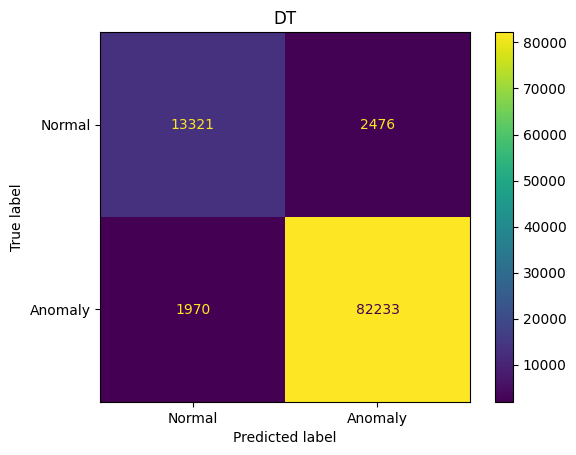

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_label, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines.items():

    X_transformed, Y_transformed = pipeline[:-1].fit_transform(X_train, Y_train)
    
    print(f"Training {pipeline_name}...")

    start_time = time.time()
    pipeline.named_steps['model'].fit(X_transformed, Y_transformed)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f} seconds")

    start_time = time.time()
    Y_pred = pipeline.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f} seconds")

    if pipeline_name == 'DT':
        print(f"Model: {pipeline_name}")
        print(evaluate_bin(pipeline_name, Y_test, Y_pred))
        print("\n")

## RF selection

In [106]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),          
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(2500)),
    ('model', SVC(kernel='poly', C= 1, degree= 3, probability= True))
    ])

Pipeline_KNN = Pipeline([
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),  
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(2500)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),  
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(8000)),
    ('model', RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.4, max_samples= 0.4, n_estimators= 80))
    ])

Pipeline_DT = Pipeline([
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(8000)),
    ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth=5, random_state=22))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('DT', Pipeline_DT)], voting='soft')

# Dictionary of pipelines
pipelines = {
    #'Vote': Vote_clf,
    'RF': Pipeline_RF,
    'SVC': Pipeline_SVC,
    'KNN': Pipeline_KNN,
    'DT': Pipeline_DT
    }

Training RF...
Training time: 0.4020 seconds
Testing time: 0.4955 seconds
Training SVC...
Training time: 0.7629 seconds
Testing time: 4.3901 seconds
Training KNN...
Training time: 0.0011 seconds
Testing time: 0.8868 seconds
Training DT...
Training time: 0.0223 seconds
Testing time: 0.1985 seconds
Model: DT
         Average Accuracy Score  Precision     Recall   F1-Score       FPR
Anomaly                  92.776   98.05481  93.271024  95.603111  9.862632




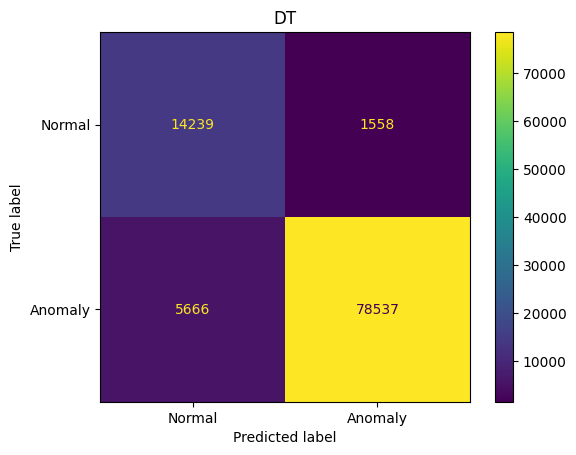

In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_label, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines.items():

    X_transformed, Y_transformed = pipeline[:-1].fit_transform(X_train, Y_train)
    
    print(f"Training {pipeline_name}...")

    start_time = time.time()
    pipeline.named_steps['model'].fit(X_transformed, Y_transformed)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f} seconds")

    start_time = time.time()
    Y_pred = pipeline.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f} seconds")

    if pipeline_name == 'DT':
        print(f"Model: {pipeline_name}")
        print(evaluate_bin(pipeline_name, Y_test, Y_pred))
        print("\n")

# Multiclass

## Normal

In [110]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),        
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('model', SVC(decision_function_shape='ovo', kernel='rbf', C= 1e4, probability=True))
    ])

Pipeline_LinSVC = Pipeline([
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('model', CalibratedClassifierCV(LinearSVC(dual= 'auto', max_iter= 1500, fit_intercept= False, loss= 'squared_hinge', penalty= 'l2', C= 30)))
    ])

Pipeline_KNN = Pipeline([
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 10000)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 8000)),
    ('model', RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80))
    ])

Pipeline_DT = Pipeline([
    ('transformer', transformer_rob_tar),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(8000)),
    ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth= 15, min_samples_leaf= 2, min_samples_split= 5, random_state=22))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('DT', Pipeline_DT), ('LinearSVC', Pipeline_LinSVC)], voting='soft')

# Dictionary of pipelines
pipelines_multi = {
    'SVC': Pipeline_SVC,
    'LinSVC': Pipeline_LinSVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'DT': Pipeline_DT
    #'Vote': Vote_clf
    }

In [111]:
X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines_multi.items():

    X_transformed, Y_transformed = pipeline[:-1].fit_transform(X_train, Y_train)
    
    print(f"Training {pipeline_name}...")

    start_time = time.time()
    pipeline.named_steps['model'].fit(X_transformed, Y_transformed)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f} seconds")

    start_time = time.time()
    Y_pred = pipeline.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f} seconds")

Training SVC...
Training time: 2.1740 seconds
Testing time: 7.1914 seconds
Training LinSVC...
Training time: 53.2525 seconds
Testing time: 0.4114 seconds
Training KNN...
Training time: 0.0022 seconds
Testing time: 10.0004 seconds
Training RF...
Training time: 4.4512 seconds
Testing time: 0.7510 seconds
Training DT...
Training time: 0.1256 seconds
Testing time: 0.2541 seconds


## PCA

In [112]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components= 5)),        
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('model', SVC(decision_function_shape='ovo', kernel='rbf', C= 1e4, probability=True))
    ])

Pipeline_LinSVC = Pipeline([
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('model', CalibratedClassifierCV(LinearSVC(dual= 'auto', max_iter= 1500, fit_intercept= False, loss= 'squared_hinge', penalty= 'l2', C= 30)))
    ])

Pipeline_KNN = Pipeline([
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 10000)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 8000)),
    ('model', RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80))
    ])

Pipeline_DT = Pipeline([
    ('transformer', transformer_rob_tar),
    ('pca', PCA(n_components= 5)),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(8000)),
    ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth= 15, min_samples_leaf= 2, min_samples_split= 5, random_state=22))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('DT', Pipeline_DT), ('LinearSVC', Pipeline_LinSVC)], voting='soft')

# Dictionary of pipelines
pipelines_multi = {
    'SVC': Pipeline_SVC,
    'LinSVC': Pipeline_LinSVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'DT': Pipeline_DT
    #'Vote': Vote_clf
    }

Training SVC...
Training time: 1.4745 seconds
Testing time: 6.8975 seconds
Training LinSVC...
Training time: 0.1575 seconds
Testing time: 0.3690 seconds
Training KNN...
Training time: 0.0116 seconds
Testing time: 0.7033 seconds
Training RF...
Training time: 0.8779 seconds
Testing time: 0.6992 seconds
Training DT...
Training time: 0.0230 seconds
Testing time: 0.2558 seconds
Model: DT
   Accuracy  Precison    Recall  F1-Score
1   0.82744  0.959110  0.791795  0.867458
2   0.82744  0.582516  0.917929  0.712733
3   0.82744  0.904564  0.919831  0.912134
4   0.82744  0.717175  0.823688  0.766750
5   0.82744  0.957181  0.817338  0.881749
6   0.82744  0.967481  0.839970  0.899227




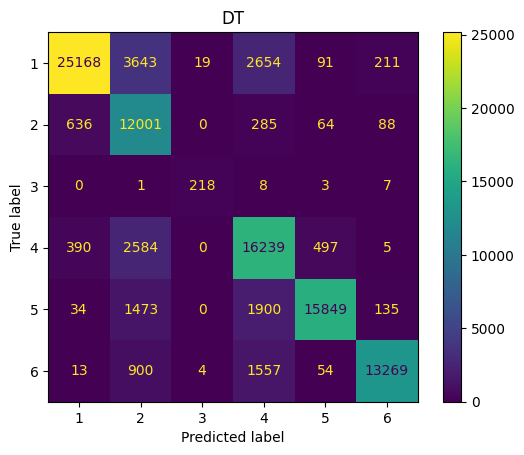

In [113]:
X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines_multi.items():

    X_transformed, Y_transformed = pipeline[:-1].fit_transform(X_train, Y_train)
    
    print(f"Training {pipeline_name}...")

    start_time = time.time()
    pipeline.named_steps['model'].fit(X_transformed, Y_transformed)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f} seconds")

    start_time = time.time()
    Y_pred = pipeline.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f} seconds")

if pipeline_name == 'DT':
    print(f"Model: {pipeline_name}")
    print(evaluate_clf(pipeline, pipeline_name, Y_test, Y_pred))
    print("\n")

## RF selection

In [114]:
# Pipelines
Pipeline_SVC = Pipeline([
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),     
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('model', SVC(decision_function_shape='ovo', kernel='rbf', C= 1e4, probability=True))
    ])

Pipeline_LinSVC = Pipeline([
    ('transformer', transformer_pass_tar),
    ('scale', StandardScaler()),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 4000)),
    ('model', CalibratedClassifierCV(LinearSVC(dual= 'auto', max_iter= 1500, fit_intercept= False, loss= 'squared_hinge', penalty= 'l2', C= 30)))
    ])

Pipeline_KNN = Pipeline([
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 10000)),
    ('model', KNeighborsClassifier(leaf_size= 2, n_neighbors= 2, p= 1, weights= 'distance'))
    ])

Pipeline_RF = Pipeline([
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(max_train_samples= 8000)),
    ('model', RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 0.8, max_samples= 0.8, n_estimators= 80))
    ])

Pipeline_DT = Pipeline([
    ('transformer', transformer_rob_tar),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=22), threshold= 0.0025)),
    ('smote', SMOTEENN(random_state= 22)),
    ('subsample', SampleSubsetSelector(8000)),
    ('model', DecisionTreeClassifier(criterion= 'entropy', max_depth= 15, min_samples_leaf= 2, min_samples_split= 5, random_state=22))
    ])

Vote_clf = VotingClassifier(estimators=[('SVC', Pipeline_SVC), ('KNN', Pipeline_KNN), ('DT', Pipeline_DT), ('LinearSVC', Pipeline_LinSVC)], voting='soft')

# Dictionary of pipelines
pipelines_multi = {
    'SVC': Pipeline_SVC,
    'LinSVC': Pipeline_LinSVC,
    'KNN': Pipeline_KNN,
    'RF': Pipeline_RF,
    'DT': Pipeline_DT
    #'Vote': Vote_clf
    }

Training SVC...
Training time: 3.3119 seconds
Testing time: 4.7251 seconds
Training LinSVC...
Training time: 3.7587 seconds
Testing time: 0.4011 seconds
Training KNN...
Training time: 0.0019 seconds
Testing time: 3.2171 seconds
Training RF...
Training time: 1.7252 seconds
Testing time: 0.7082 seconds
Training DT...
Training time: 0.0450 seconds
Testing time: 0.2938 seconds
Model: DT
   Accuracy  Precison    Recall  F1-Score
1   0.89769  0.986783  0.904329  0.943759
2   0.89769  0.911741  0.956861  0.933756
3   0.89769  0.986364  0.915612  0.949672
4   0.89769  0.699959  0.943444  0.803664
5   0.89769  0.975598  0.845341  0.905811
6   0.89769  0.981629  0.842249  0.906613




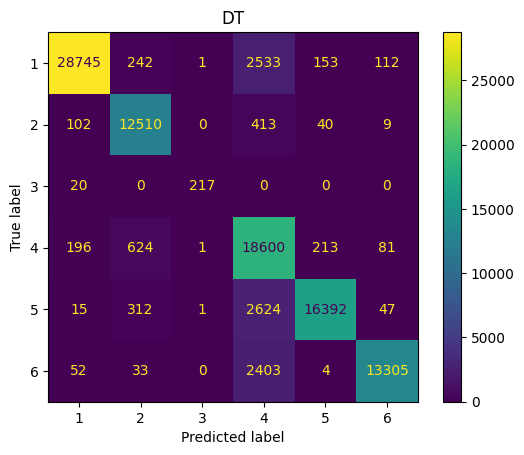

In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(Data, Attack_type, train_size=20000, test_size=100000, random_state=22, stratify= Attack_type)

for pipeline_name, pipeline in pipelines_multi.items():

    X_transformed, Y_transformed = pipeline[:-1].fit_transform(X_train, Y_train)
    
    print(f"Training {pipeline_name}...")

    start_time = time.time()
    pipeline.named_steps['model'].fit(X_transformed, Y_transformed)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training time: {training_time:.4f} seconds")

    start_time = time.time()
    Y_pred = pipeline.predict(X_test)
    end_time = time.time()
    testing_time = end_time - start_time
    print(f"Testing time: {testing_time:.4f} seconds")

if pipeline_name == 'DT':
    print(f"Model: {pipeline_name}")
    print(evaluate_clf(pipeline, pipeline_name, Y_test, Y_pred))
    print("\n")